# VL11: Multiple Regression & Panelmodelle

### Set-Up

In [2]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


## Multiple Lineare Regression

Nachdem wir nun in die multiple Regression mit mehreren Features eingeführt wurden, möchten wir dessen Aussagekraft zuerst wieder mit einem linearen Regressionsmodel testen. Dazu nutzen wir verschiedene Features:
* Numerische: Transaktionsbetrag, Transaktionsjahr, Transaktionstag, Transaktionsstunde, Alter des Käufers
* Kategorische: Verkäufer, Kategorie, Staat, Beruf

Die kategorischen Features wurden hier mittels einem OneHotEncoder entsprechend enkodiert, d.h. es gibt bei $k$ unique Werte eines Features $k-1$ Spalten, welche jeweils mit 0 (Kategorie trifft nicht zu) bzw. 1 (Kategorie trifft zu) enkodiert werden.

Ebenso wird beim Trainieren des linearen Regressionsmodels ein Train-/Test-Split von 70%/30% des gesamten Datensatzes verwendet, um das Modell zuerst auf 70% der Daten zu trainieren und anschliessend auf den Vorhersagen auf den restlichen 30% der Features zu testen, wie gut die Performance ist. Dies würde beispielsweise aufzeigen, wenn das Modell zu "overfitted" wäre, d.h. die Varianz in den Trainingsdaten modelliert hat, welche dann natürlich in den Test-Daten nicht mehr vorhanden wäre.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

y = ds["is_fraud"].copy()
X = ds[["trans_date_trans_time", "merchant", "category", "amt", "state", "job", "dob"]].copy()

# Datenvorbereitung
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["trans_day"] = X["trans_date_trans_time"].dt.day
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]

X = X.drop(columns=["trans_date_trans_time", "dob"])

categorical_features = ["merchant", "category", "state", "job"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_day", "trans_hour", "age"]

# One-Hot-Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"  # lässt numerische Spalten unverändert
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Nachdem das Modell nun gefittet sowie die Predictions auf dem Test-Teildatensatz gemacht wurden, zeigen wir im Anschluss die Performance des Modells. Auch hier sei wieder erwähnt, dass wir ein lineares Modell auf ein Klassifikationsproblem anwenden, was aus verschiedenen Gründen (Target-Var ausserhalb 0 und 1 möglich, Annahmen der linearen Reg. bzgl. Residuen verletzt, etc.) nicht optimal ist. Ebenso ist die Klassifikation mit Threshold von 0.5 (d.h. wir klassifizieren eine Transaktion als Fraud wenn unser Lineares "Wahrscheinlichkeitsmodell" eine Wahrscheinlichkeit von $\geq 0.5$ voraussagt) praktisch nutzlos, denn unsere Klassen Fraud & kein Fraud sind stark unausgeglichen in unserem Datensatz, d.h. die allermeisten Beobachtungen sind kein Fraud. Trotzdem sehen wir in der ROC-Kurve ganz unabhängig vom Threshold die Performance unseres Modells.

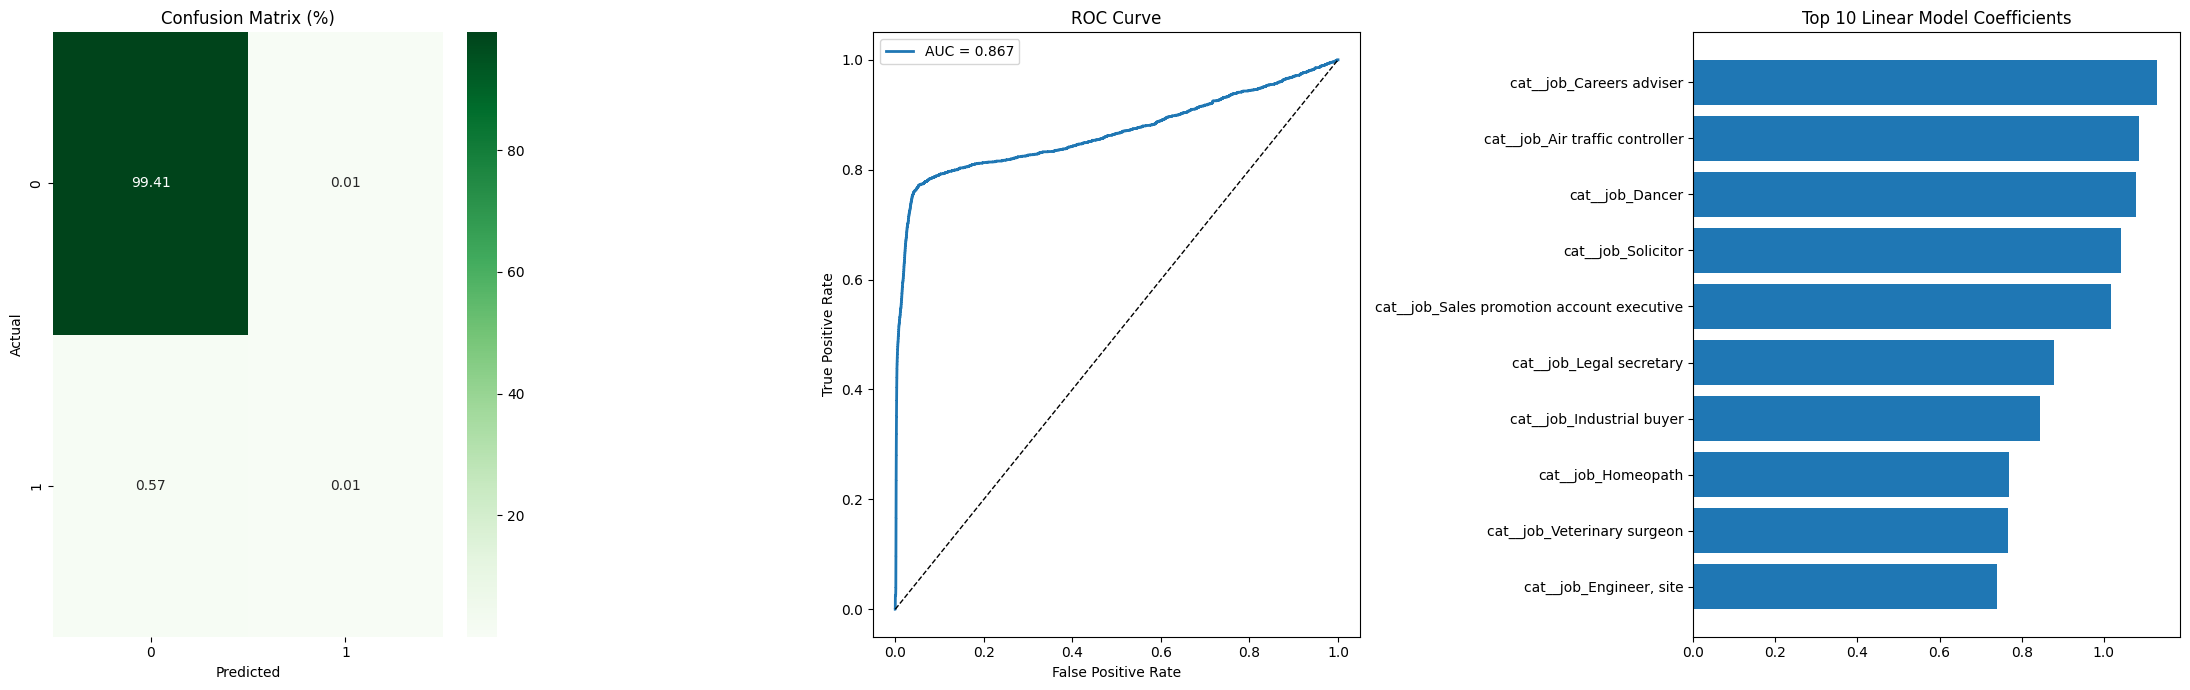

R-Quadrat: -0.0031


In [4]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, r2_score

# Vorhersage + Schwellenwertbildung
y_prob = model.predict(X_test)                   # Dauer output
y_pred = (y_prob >= 0.5).astype(int)             # in Klassenbezeichnungen umwandeln

# Konfusions Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

# ROC Kurven Daten
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)


# Feature-Bedeutung (Regressionskoeffizienten)
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coef = model.named_steps["classifier"].coef_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

# nach absolutem Gewicht sortieren
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)
top_feat = feat_imp.head(10)


# Figur mit 3 Subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Konfusions Matrix
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Kurve
axes[1].plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", linewidth=2)
axes[1].plot([0,1], [0,1], "k--", linewidth=1)
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

# Wichtigkeit der Funktion
axes[2].barh(top_feat["Feature"], top_feat["Coefficient"])
axes[2].invert_yaxis()
axes[2].set_title("Top 10 Linear Model Coefficients")

plt.tight_layout()
plt.show()

print(f"R-Quadrat: {r2_score(y_test, y_pred):.4f}")

Das negative $R^2$ von $-0.0031$ verdeutlicht, dass lineare Regression aufgrund der extremen Klassen-Imbalance und der hohen Anzahl an kategorialen Merkmalen schlechter abschneidet als ein naives Modell, das lediglich die durchschnittliche Betrugsrate vorhersagt. Ebenso sehen die praktisch nutzlose Klassifikation in der Konfusions-Matrix links, denn es werden gleich viele Falsch-Positiven wie Richtig-Positive erkannt. Die ROC-Kurve zeigt mit einer Area Under Curve von 0.867 wenigstens ein besseres Ergebnis als unsere einfachen linearen Modelle. Rechts ist dann noch zu sehen, welche Features die höchsten Koeffizienten im Modell haben, d.h. welche Features den grössten Ausschlag machen, ob eine Transaktion als Fraud klassifiziert wird oder nicht. Hier sehen wir ausschliesslich Berufs-Kategorien, ganz zuoberst Karriereberater, Flugverkerhslotsen und Tänzer...

## Erweitertes Feature Engineering

Nun möchten wir noch weitere Features hinzufügen, um unserem Modell zu ermöglichen, mehr Muster und Regelmässigkeiten in unseren Daten zu lernen:
* **Haversine-Distanz:** Berechnete Distanz zwischen dem Verkäufer und dem Käufer. Wir denken, dies könnte ein guter Prädiktor für Betrug sein, denn meist wird dieser Online/von weiter weg durchgeführt und nicht vor Ort im Laden selbst
* **Burst-Rate:** Berücksichtigt wie viele Transaktionen eine Kreditkarte innerhalb von 24h (rolling) durchführt. Wie wir bereits in unserer Hypothese gesehen haben, ist das Bursting Behavior für Fraud-Transaktionen höher, weshalb wir es hier auch hinzufügen wollten.

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from math import radians, sin, cos, sqrt, atan2

# Daten vorbereiten und Feature Engineering

y = ds["is_fraud"].copy()
X = ds[["trans_date_trans_time", "cc_num", "merchant", "category", "amt", "state", 
       "lat", "long", "merch_lat", "merch_long", "job", "dob"]].copy()

# Datumsfelder konvertieren
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

# Nach Zeit sortieren und Index zurücksetzen (für Rolling und CV)
X = X.sort_values("trans_date_trans_time").reset_index(drop=True)

# Haversine Distanz Funktion
def haversine(lat1, lon1, lat2, lon2):
    """Berechnet die Haversine-Distanz zwischen zwei geografischen Punkten in Kilometern."""
    R = 6371  # Erdradius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

# Anwendung der Funktion
X["distance_km"] = X.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
    axis=1
)

X = X.drop(columns=["lat", "long", "merch_lat", "merch_long"])

# Burst Rate
# Temporärer DataFrame für die Rolling-Berechnung
X_temp_for_rolling = X.copy().set_index("trans_date_trans_time")

# Berechnung der Burst Rate
burst_rate_series = (
    X_temp_for_rolling.groupby("cc_num")
    .rolling(window="24h", closed="left")
    ["amt"].count() 
    .rename('burst_rate_1d')
)


# Zuweisung zum Haupt-DataFrame X
# Wir setzen den MultiIndex in X als temporäre Spalten
X = X.set_index(['cc_num', 'trans_date_trans_time'])

# Führe den Join durch
X = X.join(burst_rate_series)

# Index wiederherstellen und temporäre Spalten entfernen
X = X.reset_index()

# NaNs füllen (Kunden, die in den letzten 24h keine Transaktion hatten)
X['burst_rate_1d'] = X['burst_rate_1d'].fillna(0)

# Weitere Zeit- und Altersfeatures
X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["weekday"] = X["trans_date_trans_time"].dt.weekday
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

# Altersberechnung
X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]


if len(X) > len(y):
    X = X.reset_index(drop=True)
    # Identifiziere Duplikate (basierend auf allen Spalten ausser der Burst Rate, da sie neu ist)
    cols_to_check = X.columns.drop(['burst_rate_1d'])
    X_original_size = X.drop_duplicates(subset=cols_to_check, keep='first')
    X = X_original_size.copy()

# unnötiges entfernen, features inkl. Kreditkartennummer und Zeit noch behalten für später
features = X.copy()
X = X.drop(columns=["dob", "birth_year", "cc_num", "trans_date_trans_time"])

# Definition der Features für Preprocessing später
categorical_features = ["merchant", "category", "state", "job", "weekday"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_hour", "age", "distance_km","burst_rate_1d"]

## Multikollinearität 

Nachdem wir alle Features erstellt haben, möchten wir diese nun auf Multikollinearität überprüfen. Dies ist wichtig, um die Koeffizienten stabil zu halten.

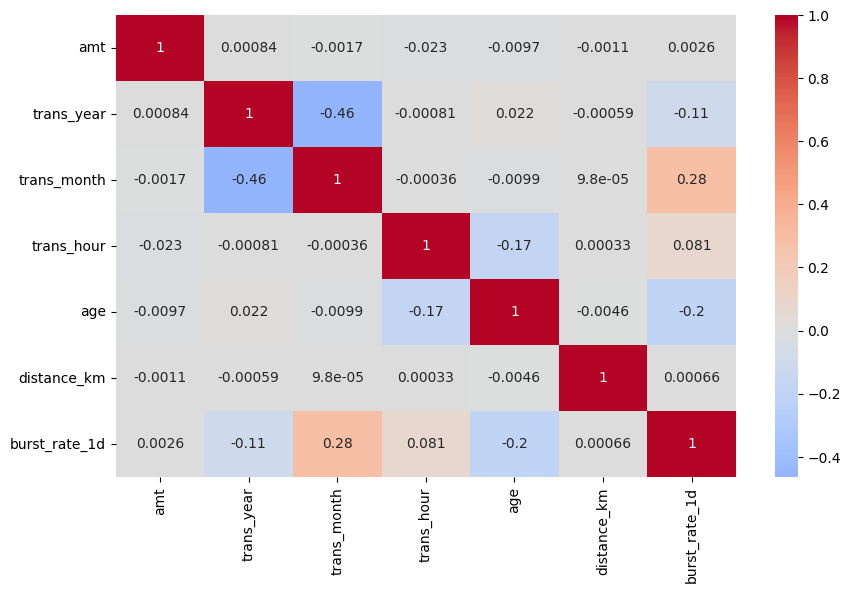

In [6]:
corr = X[numeric_features].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)
plt.show()

Wir sehen, dass nur wenige Features eine nennenswerte Korrelation aufweisen, namentlich:
* *trans_month* mit *trans_year* (-0.46)
* *trans_month* mit *burst_rate_1d* (0.28)

 Wir möchten in einem nächsten Schritt die Variance Inflation Factors berechnen um zu sehen, wie stark die Varianz durch Multikollinearität aufgeblasen wird.

### Variance Inflation Factor (VIF)

Misst, wie stark Varianz eines Koeffizienten durch Multikollinearität aufgebläht wird.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_for_vif = X[numeric_features]

# VIF DataFrame vorbereiten
vif_df = pd.DataFrame()
vif_df["feature"] = X_for_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

# Sortieren nach höchster Multikollinearität
vif_df = vif_df.sort_values("VIF", ascending=False)

vif_df

,feature,VIF
1,trans_year,25.6831
4,age,8.5791
5,distance_km,7.8337
3,trans_hour,4.6821
2,trans_month,4.6040
6,burst_rate_1d,2.9396
0,amt,1.1934


Wir sehen vor allem den extrem hohen VIF-Wert von über 25 beim Feature *trans_year*, sowie die merkliche Aufblöhung in *distance_km* und *age*. Diese behandeln wir folgendermassen:
* Wir ändern für *distance_km* sowie *age* nichts, da wir hier die Koeffizienten nicht interpretieren möchten und glauben, dass die Spalten einen wichtigen Einfluss auf das Modell haben zur reinen Vorhersage.
* Den VIF von *trans_year* möchten wir runterbringen, um die Interpretation des Koeffizienten zu ermöglichen für später. Dazu ersetzen wir die beiden Spalten *trans_year* und *trans_month* indem wir eine neue Spalte, den *time_index* bilden. Dieser wird zusammengesetzt aus dem Jahr * 12 und dem Monat, um die Information der beiden Spalten zu bündeln.


In [8]:
# Entwickeln eines kombinierten Zeitindexs für trans_year und trans_month
X["time_index"] = X["trans_year"] * 12 + X["trans_month"]
X.drop(columns=["trans_year","trans_month"],inplace=True)

# Selbe Aktion für feature dataframe
features["time_index"] = features["trans_year"] * 12 + features["trans_month"]
features.drop(columns=["trans_year","trans_month"],inplace=True)

Nun überprüfen wir erneut die Multikollinearität:

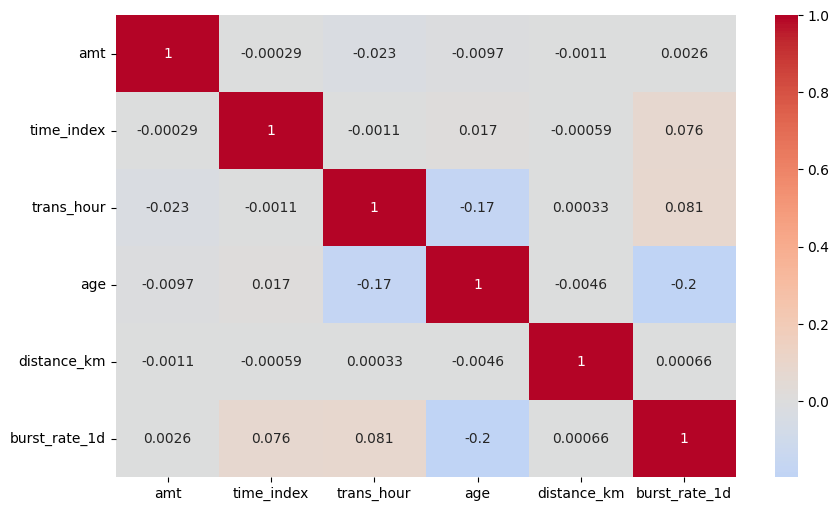

In [9]:
numeric_features = ["amt", "time_index", "trans_hour", "age","distance_km","burst_rate_1d"]
X_for_corr = X[numeric_features]

# Korrelation der standardisierten Features
corr_new = X_for_corr.corr()
sns.heatmap(corr_new, cmap="coolwarm", center=0, annot=True)
plt.show()

Wir sehen, dass nun die Multikollinearität des *trans_month* Features nicht mehr vorhanden ist, wir sind bereit, die Modelle anzugehen.

# Logistische Regression mit Cross-Validation

Nachdem wir nun alle unsere Features vorbereitet haben, befassten wir uns mit den Modellen. Hier nutzen wir nun ein Logistisches Regressionmodell, welches sich besser eignet für Klassifikation als ein lineares Modell aufgrund des Outputs, welcher immer zwischen 0 und 1 sein wird. Weitere nennenswerte Techniken / Entscheidungen:
* **Pipeline:** Wendet zuerst die definierten Preprocessing-Schritte an (z-Standardisierung für numerische, One-Hot-Encoding für kategorische Features), und definiert anschliessend Modell. Dort zu erwähnen ist der Paramteer *class_weight="balanced"*, denn unsere Klassen (Betrug / kein Betrug) sind im Datensatz sehr stark unausgeglichen. Dies ist sehr wichtig, damit das Modell richtig lernen kann und sensitiver wird (denn die Los-Funktion wird so gewichtet, dass ein Fehler in der unterrepräsentierten Klasse (Fraud, d.h. ein Falsch-Negativer Fehler) stärker reinzählt)
* **Zeitreihen Cross-Valdiation:** Wir nutzten CV für Time-Series mit 5 Folds, um die Performance des Modells robuster beurteilen zu können über verschiedene Zeiträume. Ganz am Schluss wird dann das Modell auf ungesehenen Daten getestet, um die erwartete Performance im praktischen Einsatz zu zeigen.
* **Threshold-Wahl:** Entscheidungs-Threshold wurde auf dem Trainingsdatensatz so gewählt, dass ein Recall von mindestens 80% erreicht wird auf Betrug. Dieser wurde anschliessend unverändert auf den zeitlich getrennten Testdatensatz angewendet.

In [10]:
from sklearn.metrics import make_scorer, average_precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced", # Wichtig, um die starke Imbalance der Klassen (Fraud/Non-Fraud) auszugleichen
        solver="liblinear", 
        random_state=42,
        max_iter=500
    ))
])

# TimeSeries Split
# Folds zur Überprüfung der zeitlichen Stabilität
tscv = TimeSeriesSplit(n_splits=5)

# Ausführung der Cross-Validation
print("\nStarte TimeSeries Cross-Validation...")

cv_results = cross_val_score(
    estimator=pipeline,
    X=X, # Gesamter Feature-Satz
    y=y, # Gesamte Zielvariable
    cv=tscv, # Die TimeSeriesSplit-Strategie
    scoring="average_precision", # Die Metrik (Average Precision, nimmt Performance über alle Thresholds)
    n_jobs=-1, # Nutzt alle verfügbaren Kerne
)

print("\n--- Ergebnisse der TimeSeries Cross-Validation ---")
print(f"Metrik: Average Precision (PR AUC)")
print(f"Einzelne Fold-Ergebnisse (über die Zeit): {cv_results}")


# Finaler Time-Series-Split (70/30)
# Da X bereits nach Zeit sortiert ist, verwenden wir einen indexbasierten Split.

total_samples = len(X)
train_size = int(total_samples * 0.7)

# X_train und X_test über den Index trennen
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

# y_train und y_test über den Index trennen
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print("\n--- Finaler Time-Series-Split ---")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")


# Modell trainieren und Vorhersagen treffen
# Das Modell wird auf dem Training-Set neu trainiert
print("\nTrainiere Modell für Performance-Vorhersage...")
pipeline.fit(X_train, y_train)

# Wahrscheinlichkeiten für die positive Klasse (1, Betrug)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Threshold
threshold = 0.03
y_pred = (y_pred_prob >= threshold).astype(int)


# Metriken ausgeben
print("=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===")

# Klassifikationsbericht
print("\nClassification Report (Threshold "+str(threshold)+"):\n")
# Dieser Bericht zeigt Precision, Recall und F1-Score für beide Klassen.
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
print("\nConfusion Matrix (Threshold "+str(threshold)+"):\n")
print(confusion_matrix(y_test, y_pred))

# AUC-ROC Score
auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score (Gesamtfläche): {auc:.4f}")

# PR AUC (Average Precision)
pr_auc = average_precision_score(y_test, y_pred_prob)
print(f"PR AUC Score (Average Precision): {pr_auc:.4f}")
fraud_rate = y.mean()
print(f"Zum Vergleich Baseline Fraud-Rate: {fraud_rate:.4f}")


Starte TimeSeries Cross-Validation...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during trans


--- Ergebnisse der TimeSeries Cross-Validation ---
Metrik: Average Precision (PR AUC)
Einzelne Fold-Ergebnisse (über die Zeit): [0.02743825 0.03113387 0.05757156 0.07269163 0.08448272]

--- Finaler Time-Series-Split ---
Training Samples: 907672
Test Samples: 389003

Trainiere Modell für Performance-Vorhersage...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===

Classification Report (Threshold 0.03):

              precision    recall  f1-score   support

           0       1.00      0.52      0.68    386618
           1       0.01      0.79      0.02      2385

    accuracy                           0.52    389003
   macro avg       0.50      0.65      0.35    389003
weighted avg       0.99      0.52      0.68    389003


Confusion Matrix (Threshold 0.03):

[[199571 187047]
 [   511   1874]]

AUC-ROC Score (Gesamtfläche): 0.7654
PR AUC Score (Average Precision): 0.0781
Zum Vergleich Baseline Fraud-Rate: 0.0058


Wir sehen, dass bei dem gewählten (sehr tiefen) Threshold von 0.03 (d.h. wenn das Modell die Transaktion zu 3% oder mehr als Betrug wertet, klassifiziert sie die Transaktion als Betrug) können wir so einen Recall-Wert von knapp 80% erreichen (was unser Ziel war, deswegen auch genau dieser Threshold-Wert). Darunter leidet aber natürlich die Precision extrem stark, denn es gibt immer ein Tradeoff zwischen Precision & Recall. Mit unserem Business Case der Betrugserkennung ist dieser starke Fokus auf Recall aber klar, denn einen Betrugsfall nicht zu erknennen ist für den Nutzer unseres Modells (bspw. ein Kreditkartenherausgeber oder eine Bank) viel teurer als eine Transaktion fälschlicherweise als Betrug zu klassifizieren und dann zu merken, dass es doch keiner war. Allerdings hat unser Modell mit etwa 1% Precision auf Betrug eine wirklich schlechte Genauigkeit, weswegen absolut gesehen über 180'000 Transaktionen fälschlicherweise als Betrug klassifiziert wurden. Allerdings ist es mit einer Average Precision von 0.078 bei einer Fraud-Rate aller Daten von 0.58% rund 13x besser als Zufall.

### Ausgabe der Ergebnisse

Wir sehen uns nun 3 wichtige Plots an zu unserem Modell:
* **Klassifikationsmatrix prozentual:** Bereits bekannt vom linearen Regressionsmodell
* **Precision-Recall-Curve:** Zeigt die Veränderung der Precision & des Recalls je nach gewähltem Threshold-Wert. Ebenso ist in rot unser gewählter Threshold markiert, um zu sehen wo dieser einzuordnen ist.
* **Top Feature Koeffizienten:** Ebenfalls bereits bekannt, werden hier die aussagekräftigsten Features, gemessen an ihrem Koeffizienten, ausgegeben. Dabei werden die Top 15 der kategorischen Features sowie die Top 5 der numerischen Features gezeigt, um beide Klassen abzubilden.

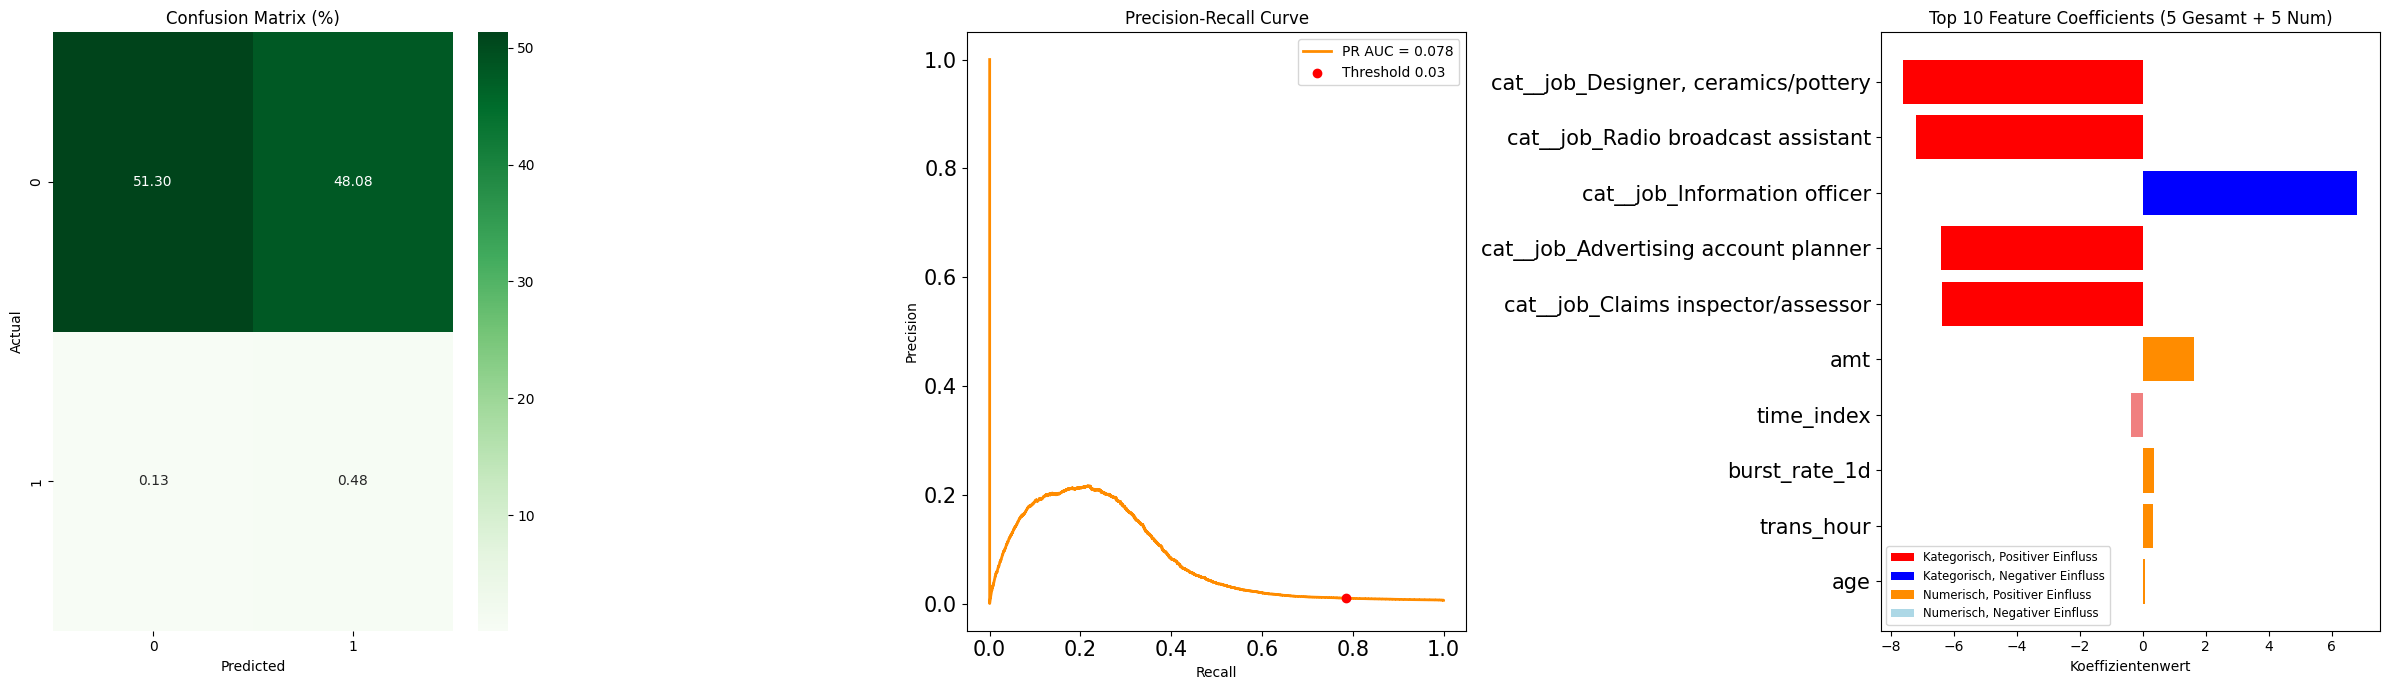

merchant: gedroppte Kategorie = fraud_Abbott-Rogahn
category: gedroppte Kategorie = entertainment
state: gedroppte Kategorie = AK
job: gedroppte Kategorie = Academic librarian
weekday: gedroppte Kategorie = 0


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from matplotlib.patches import Patch # Für die Legende

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Marker für Threshold
threshold_05_idx = np.argmin(np.abs(thresholds - threshold))
pr_threshold_x = recall[threshold_05_idx]
pr_threshold_y = precision[threshold_05_idx]

# Datenvorbereitung
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coef = pipeline.named_steps["classifier"].coef_[0]

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})
# Sortiert nach der absoluten Größe des Koeffizienten
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)

#  Neue Listen erstellen

# Numerische Features
num_feat_imp = feat_imp[feat_imp['Feature'].str.startswith('num__')].copy()

# Top 15 Features insgesamt (kategorisch & numerisch)
top_15_total = feat_imp.head(5)

# Top 5 numerische Features
top_5_num = num_feat_imp.head(5)

# Kombinieren der Listen
# Hinzufügen der Top 5 numerischen Features zur Top 15 Gesamt
combined_feat = pd.concat([top_15_total, top_5_num]).drop_duplicates(subset=['Feature'])

# Sortiere die finale Liste der Features erneut nach absoluter Wichtigkeit
final_feat_list = combined_feat.reindex(combined_feat.Coefficient.abs().sort_values(ascending=False).index)

# Bereinigen der Feature-Namen für den Plot
final_feat_list['Plot_Feature'] = final_feat_list['Feature'].str.replace('num__', '')


# Plot
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Konfusions Matrix
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Precision-Recall Kurve
axes[1].plot(recall, precision, color="darkorange", linewidth=2, label=f"PR AUC = {pr_auc:.3f}")
axes[1].scatter(pr_threshold_x, pr_threshold_y, color='red', zorder=5, label="Threshold "+str(threshold))
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].tick_params(axis='y', labelsize=15) 
axes[1].tick_params(axis='x', labelsize=15) 
axes[1].legend()

# Erstellen der Liste der Farben basierend auf Feature-Typ und Vorzeichen:
colors = []
for feature_name, coefficient in final_feat_list[["Feature", "Coefficient"]].values:
    is_numeric = feature_name.startswith('num__')
    
    if is_numeric:
        # Numerisches Feature: Hervorgehobene Farbe
        colors.append('darkorange' if coefficient > 0 else 'lightcoral')
    else:
        # Kategorisches Feature: Standardfarbe
        colors.append('blue' if coefficient > 0 else 'red')
axes[2].tick_params(axis='y', labelsize=15)
axes[2].barh(final_feat_list["Plot_Feature"], final_feat_list["Coefficient"], color=colors)
axes[2].invert_yaxis()
axes[2].set_title(f"Top {len(final_feat_list)} Feature Coefficients (5 Gesamt + 5 Num)")
axes[2].set_xlabel("Koeffizientenwert")

# Hinzufügen einer Legende für die Farbdifferenzierung
legend_elements = [
    Patch(facecolor='red', label='Kategorisch, Positiver Einfluss'),
    Patch(facecolor='blue', label='Kategorisch, Negativer Einfluss'),
    Patch(facecolor='darkorange', label='Numerisch, Positiver Einfluss'),
    Patch(facecolor='lightblue', label='Numerisch, Negativer Einfluss')
]
axes[2].legend(handles=legend_elements, loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()

# Gedroppte Kategorie anzeigen, um zu sehen was Referenz für Dummy-Effekte ist
for feature_name, categories in zip(categorical_features, pipeline.named_steps["preprocessor"].named_transformers_["cat"].categories_):
    dropped_category = categories[0]
    print(f"{feature_name}: gedroppte Kategorie = {dropped_category}")

Wir sehen nun die Ergebnisse unseres logistischen Regressionsmodell dargestellt:
* **Confusion Matrix:** Zu sehen ist hier der hohe Anteil Falsch-Positiver Klassifizierungen, welcher aber durch den Fokus auf Recall (ein False-Negative ist viel "teurer"/schwerwiegender wie ein False-Positive) abzusehen war.
* **Precision-Recall Curve:** Klar zu sehen ist der Tradeoff zwischen den beiden Werten. wir haben uns hier dazu entschieden, mindestens 80% Recall auf die Train-Daten haben zu wollen, weshalb die Precision sehr tief ist.
* **Top Features:** Hier sehen wir die Koeffizienten der Features in absteigender Reihenfolge nach absolutem Wert. Hier ist zu sehen, dass der stärkste Prädiktor FÜR Betrug der Käufer-Job eines Information Officers ist, der stärkste Prädiktor dagegen der Käufer-Job eines Keramik- & Töpfer-Designer (wobei die Koeffizienten nur als Niveauunterschiede zu interpretieren sind relativ zur Referenzkategorie (die gedroppt wurde um perfekte Kollinearität zu durchbrechen), die je Kategorie unter den Plots ausgegeben wurde). Numerisch ist der Transaktionsbetrag am relevantesten, wobei ein grösserer Betrag FÜR Fraud spricht. Ebenso ist die Burst-Rate wie bereits vermutet auch unter den Top 5 numerischen Prädiktoren.

## Panelmodelle: First Differences (FD)

Nachdem wir nun das "normale" logistische Regressionsmodell intensiv betrachtet haben, wollten wir noch einen Panelmodell-Ansatz ausprobieren. Hier entschieden wir uns klar für **First-Differences** als passendsten Ansatz für unser Datensatz. Wir wendeten die FD-Methode auf die Kreditdatennummern an, um Features für kurzfristige Veränderungen (Bursts) als untypische Verhaltensänderungen (d.h. als Betrugsindikatoren) zu schaffen. Dabei haben wir mit dem Prinzip $X_{it} = X_{it} - X_{i,t-1}$ für $i=$ Kreditkartennummer und $X:$ Distanz Verkäufer-Käufer bzw. Transkationsbeträge jeweils die Differenz des Transaktionsbetrags sowie der weiter oben berechneten Distanz (Käufer-Verkäufer) verglichen zum letzten Einkauf der gleichen Kreditkarte. Wir denken, dass in Betrugsfällen diese beiden Werte plötzlich extrem variieren können.

In [12]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, average_precision_score
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
from matplotlib.patches import Patch

# Sortieren nach Kunde und Zeit für die Differenzbildung und Rolling-Features, nutzen des feature df von oben
data = features.copy()
data["target"] = y.values

data = data.sort_values(["cc_num", "trans_date_trans_time"]).reset_index(drop=True)

X = data.drop(columns=["target"])
y = data["target"]

# First Differences (FD)
print("Erstelle First Differences Features...")
X['delta_amt'] = X.groupby('cc_num')['amt'].diff().fillna(0)
X['delta_distance_km'] = X.groupby('cc_num')['distance_km'].diff().fillna(0)

# Endgültige Features entfernen
X = X.drop(columns=["trans_date_trans_time", "cc_num"]) 

categorical_features = ["merchant", "category", "state", "job", "weekday"]
numeric_features = ["amt", "time_index", "trans_hour", "age", "distance_km", "burst_rate_1d", "delta_amt", "delta_distance_km"]                  

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features) 
    ],
    remainder="drop" # Nicht verwendete Spalten entfernen
)

# TimeSeries Cross-Validation

# Pipeline Definition 
# Rückkehr zur Logistischen Regression mit balanced class_weight
pipeline_logreg_fd = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced", # Wichtig für unausgewogene Daten
        solver="liblinear", 
        random_state=42,
        max_iter=500
    ))
])

# Metrik und Split
tscv = TimeSeriesSplit(n_splits=5)

print("\nStarte TimeSeries Cross-Validation (LogReg mit FD)...")

cv_results_logreg_fd = cross_val_score(
    estimator=pipeline_logreg_fd,
    X=X, 
    y=y, 
    cv=tscv, 
    scoring="average_precision", 
    n_jobs=-1
)

print("\n--- Ergebnisse der TimeSeries Cross-Validation (LogReg mit FD) ---")
print(f"Metrik: Average Precision (PR AUC)")
print(f"Einzelne Fold-Ergebnisse: {cv_results_logreg_fd}")


# Finaler Time-Series-Split (70/30)
# Da X bereits nach Zeit sortiert ist, verwenden wir einen indexbasierten Split.
total_samples = len(X)
train_size = int(total_samples * 0.7)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

# y wurde bereits synchronisiert und auf den gleichen Index gebracht
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print("--- Finaler Time-Series-Split ---")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")


# Modell trainieren und Vorhersagen treffen
print("\nTrainiere Logistisches Regressions Modell mit FD zur Performance-Vorhersage...")
pipeline_logreg_fd.fit(X_train, y_train)

# Wahrscheinlichkeiten für die positive Klasse (1, Betrug)
y_pred_prob = pipeline_logreg_fd.predict_proba(X_test)[:, 1]

# Threshold so gewählt, dass wir mindestens 90% Recall auf Betrugsfälle haben
threshold = 0.09
y_pred = (y_pred_prob >= threshold).astype(int)


# Metriken und Daten für Plots berechnen
auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)


print("=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===")
print(f"=== Modell: Logistische Regression (mit FD) | Threshold: {threshold:.2f} ===")


print("\nClassification Report (Threshold "+str(threshold)+"):\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix (Threshold "+str(threshold)+"):\n")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score: {auc:.4f}")
print(f"PR AUC Score (Average Precision): {pr_auc:.4f}")
fraud_rate = y.mean()
print(f"Zum Vergleich Baseline Fraud-Rate: {fraud_rate:.4f}")

Erstelle First Differences Features...

Starte TimeSeries Cross-Validation (LogReg mit FD)...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during


--- Ergebnisse der TimeSeries Cross-Validation (LogReg mit FD) ---
Metrik: Average Precision (PR AUC)
Einzelne Fold-Ergebnisse: [0.12654579 0.14763016 0.11015099 0.17406808 0.19957691]
--- Finaler Time-Series-Split ---
Training Samples: 907672
Test Samples: 389003

Trainiere Logistisches Regressions Modell mit FD zur Performance-Vorhersage...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===
=== Modell: Logistische Regression (mit FD) | Threshold: 0.09 ===

Classification Report (Threshold 0.09):

              precision    recall  f1-score   support

           0       1.00      0.59      0.74    386689
           1       0.01      0.90      0.03      2314

    accuracy                           0.59    389003
   macro avg       0.51      0.74      0.38    389003
weighted avg       0.99      0.59      0.73    389003


Confusion Matrix (Threshold 0.09):

[[226420 160269]
 [   222   2092]]

AUC-ROC Score: 0.8941
PR AUC Score (Average Precision): 0.1878
Zum Vergleich Baseline Fraud-Rate: 0.0058


Verglichen zum vorherigen Modell sehen wir eine klare Verbesserung der Average Precision von 7.8% auf 18.78%, das Modell ist nun also 32x besser als Zufall bei der Identifikation von Betrug, wir haben also deutlich weniger False Positives für denselben Recall und die Modellqualität hat sich mehr als verdoppelt. Wir haben uns deswegen dazu entschieden, den Recall noch weiter oben anzusetzen und den Threshold so zu wählen, dass wir 90% Recall auf Betrug erreichen.

### Ausgabe der Ergebnisse

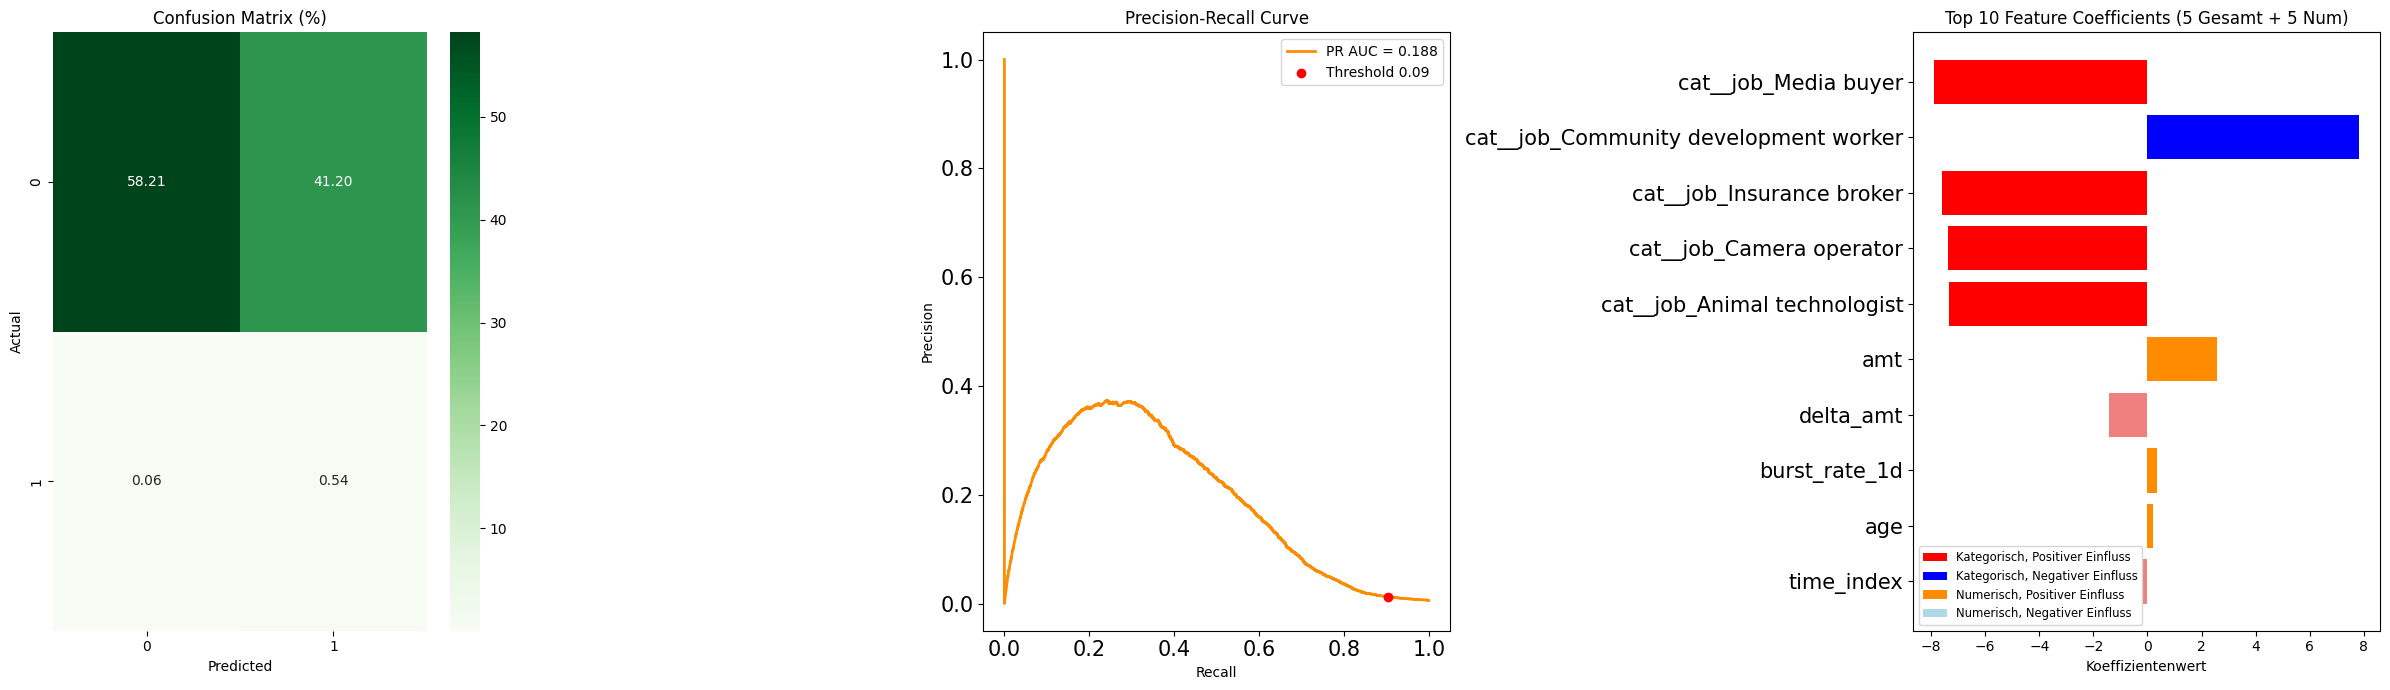

merchant: gedroppte Kategorie = fraud_Abbott-Rogahn
category: gedroppte Kategorie = entertainment
state: gedroppte Kategorie = AK
job: gedroppte Kategorie = Academic librarian
weekday: gedroppte Kategorie = 0


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from matplotlib.patches import Patch # Für die Legende

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Marker für Threshold
threshold_05_idx = np.argmin(np.abs(thresholds - threshold))
pr_threshold_x = recall[threshold_05_idx]
pr_threshold_y = precision[threshold_05_idx]

# Datenvorbereitung
feature_names = pipeline_logreg_fd.named_steps["preprocessor"].get_feature_names_out()
coef = pipeline_logreg_fd.named_steps["classifier"].coef_[0]

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})
# Sortiert nach der absoluten Größe des Koeffizienten
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)

#  Neue Listen erstellen

# Numerische Features
num_feat_imp = feat_imp[feat_imp['Feature'].str.startswith('num__')].copy()

# Top 15 Features insgesamt (kategorisch & numerisch)
top_15_total = feat_imp.head(5)

# Top 5 numerische Features
top_5_num = num_feat_imp.head(5)

# Kombinieren der Listen
# Hinzufügen der Top 5 numerischen Features zur Top 15 Gesamt
combined_feat = pd.concat([top_15_total, top_5_num]).drop_duplicates(subset=['Feature'])

# Sortiere die finale Liste der Features erneut nach absoluter Wichtigkeit
final_feat_list = combined_feat.reindex(combined_feat.Coefficient.abs().sort_values(ascending=False).index)

# Bereinigen der Feature-Namen für den Plot
final_feat_list['Plot_Feature'] = final_feat_list['Feature'].str.replace('num__', '')


# Plot
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Konfusions Matrix
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Precision-Recall Kurve
axes[1].plot(recall, precision, color="darkorange", linewidth=2, label=f"PR AUC = {pr_auc:.3f}")
axes[1].scatter(pr_threshold_x, pr_threshold_y, color='red', zorder=5, label="Threshold "+str(threshold))
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].tick_params(axis='y', labelsize=15) 
axes[1].tick_params(axis='x', labelsize=15) 
axes[1].legend()

# Erstellen der Liste der Farben basierend auf Feature-Typ und Vorzeichen:
colors = []
for feature_name, coefficient in final_feat_list[["Feature", "Coefficient"]].values:
    is_numeric = feature_name.startswith('num__')
    
    if is_numeric:
        # Numerisches Feature: Hervorgehobene Farbe
        colors.append('darkorange' if coefficient > 0 else 'lightcoral')
    else:
        # Kategorisches Feature: Standardfarbe
        colors.append('blue' if coefficient > 0 else 'red')
axes[2].tick_params(axis='y', labelsize=15)
axes[2].barh(final_feat_list["Plot_Feature"], final_feat_list["Coefficient"], color=colors)
axes[2].invert_yaxis()
axes[2].set_title(f"Top {len(final_feat_list)} Feature Coefficients (5 Gesamt + 5 Num)")
axes[2].set_xlabel("Koeffizientenwert")

# Hinzufügen einer Legende für die Farbdifferenzierung
legend_elements = [
    Patch(facecolor='red', label='Kategorisch, Positiver Einfluss'),
    Patch(facecolor='blue', label='Kategorisch, Negativer Einfluss'),
    Patch(facecolor='darkorange', label='Numerisch, Positiver Einfluss'),
    Patch(facecolor='lightblue', label='Numerisch, Negativer Einfluss')
]
axes[2].legend(handles=legend_elements, loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()

# Gedroppte Kategorie anzeigen, um zu sehen was Referenz für Dummy-Effekte ist
for feature_name, categories in zip(categorical_features, pipeline_logreg_fd.named_steps["preprocessor"].named_transformers_["cat"].categories_):
    dropped_category = categories[0]
    print(f"{feature_name}: gedroppte Kategorie = {dropped_category}")

Auch hier sehen wir die klar bessere Modellqualität, einerseits im Verlauf der Precision-Recall Curve, welche zeigt wie mit steigendem Recall die Precision viel langsamer abnimmt als zuvor, und andererseits in der Confusion Matrix, wo wir nun prozentual weniger False-Positives klassifizieren. Interessant sind die Top Feature Koeffizienten, wo bei den kategorischen alle gänzlich neu sind (die Referenzkategorie ist gleich zu vorhin, d.h. die Niveauunterschiede sind relativ zur gleichen Kategorie zu sehen). Bei den numerischen zeigt sich erfreulicherweise unser neu hinzugefügtes First-Difference-Feature *delta_amt* als zweit-wichtigstes gemessen am Koeffizienten, wobei ironischerweise eine höhere Differenz zwischen den letzten beiden Transaktionen auf eine kleinere Wahrscheinlichkeit auf Fraud hinweist.

# Fazit

Unsere Analyse zeigt, dass die Betrugserkennung mittels Regressionsmodellen recht schwierig ist. Am Ende konnten wir mit dem Wechsel von der Standard-Logistical-Regression auf unseren Panel-Ansatz mit First Differences noch einen kleinen Durchbruch in Performance feiern, womit das finale Modell nun deutlich effizienter ist und den kritischen Recall von 90% mit signifikant weniger Fale-Positives als das Standardmodell erreicht. Es zeigt, dass die Berücksichtigung der zeitlichen Dynamik im Kundenverhalten das Modell präziser und geeigneter für den Praxiseinsatz macht.